In [129]:
import os
import numpy as np
import librosa
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Data collection

For training and validation data, we used other students' data from FreeSound.org.  For testing data, we used our own data we have collected.  
As reccommended, we splitted the data into the ratio of 70/15/15 with 70% is training data, 15% is validation data and 15% is testing data.

In [130]:
#training data
path_car_train = 'training/car/*.wav'
path_tram_train = 'training/tram/*.wav'
#validation data
path_car_valid = 'validation/car/*.wav'
path_tram_valid = 'validation/tram/*.wav'
#testing data
path_car_test = 'testing/car/*.wav'
path_tram_test = 'testing/tram/*.wav'

car_train = [librosa.load(os.fspath(p))[0] for p in Path().glob(path_car_train)]
tram_train = [librosa.load(os.fspath(p))[0] for p in Path().glob(path_tram_train)]
print('{} car training signals - {} tram training signals'.format(len(car_train), len(tram_train)))

car_valid = [librosa.load(os.fspath(p))[0] for p in Path().glob(path_car_valid)]
tram_valid = [librosa.load(os.fspath(p))[0] for p in Path().glob(path_tram_valid)]
print('{} car validation signals - {} tram validation signals'.format(len(car_valid), len(tram_valid)))

car_test = [librosa.load(os.fspath(p))[0] for p in Path().glob(path_car_test)]
tram_test = [librosa.load(os.fspath(p))[0] for p in Path().glob(path_tram_test)]
print('{} car testing signals - {} tram testing signals'.format(len(car_test), len(tram_test)))

103 car training signals - 96 tram training signals
18 car validation signals - 21 tram validation signals
20 car testing signals - 20 tram testing signals


# 2. Feature extraction 

In this part, we will extract some possible features from the audio files to evaluate and choose the feature that will be the most suitable for the model. 

In [131]:
#function including all possible features we can extract from the audio files
def extract_all_features(signal):
    return [
        #zero crossing rate
        librosa.feature.zero_crossing_rate(y=signal)[0, 0],
        #chroma energy
        librosa.feature.chroma_cens(y=signal)[0, 0],
        #mfcc
        librosa.feature.mfcc(y=signal)[0, 0],
        #RMS
        librosa.feature.rms(y=signal)[0, 0],
        #Scectral centroid
        librosa.feature.spectral_centroid(y=signal)[0, 0]
    ]

In [132]:
car_features = np.array([extract_all_features(x) for x in car_train])
tram_features = np.array([extract_all_features(x) for x in tram_train])

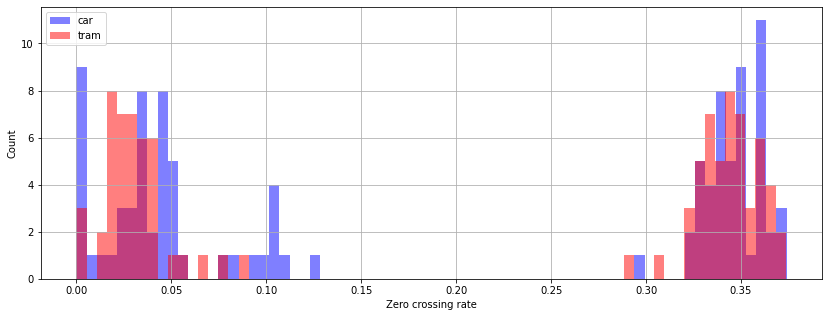

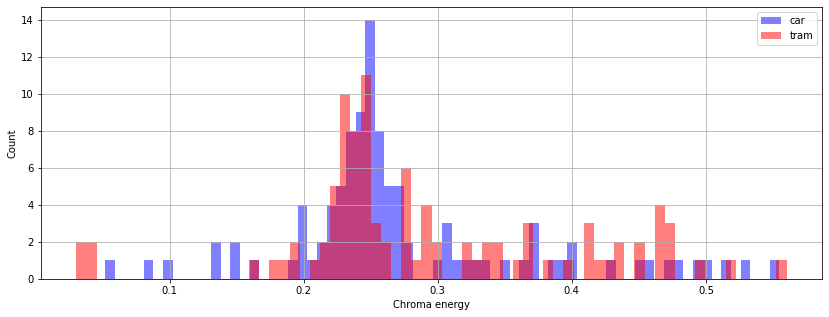

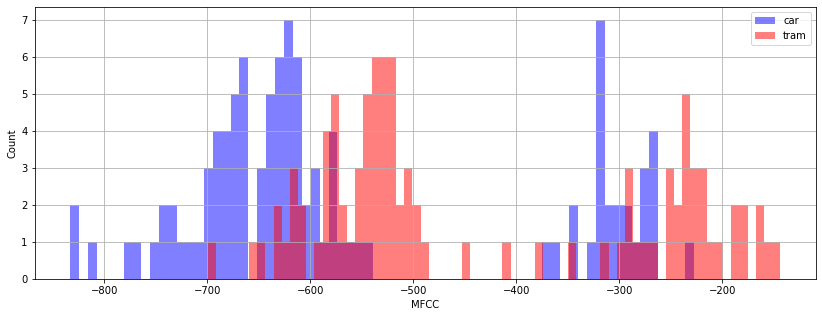

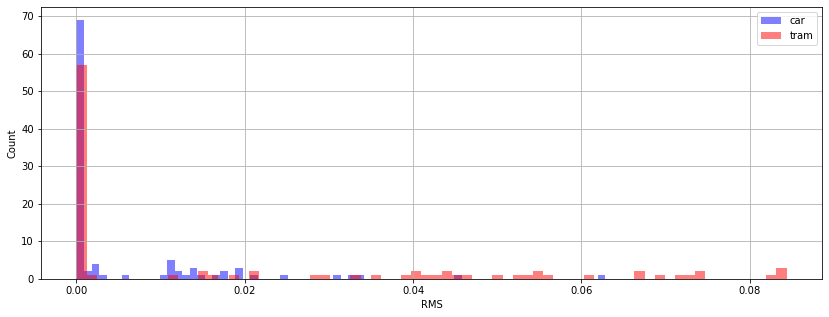

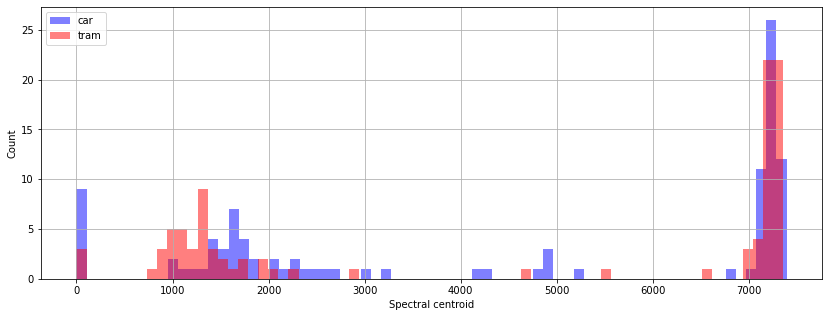

In [133]:
features = ["Zero crossing rate", "Chroma energy", "MFCC", "RMS", "Spectral centroid"]
for index in range(5):
    plt.figure(figsize = (14,5))
    plt.hist(car_features[:,index], color = 'b', bins = 70, alpha = 0.5)
    plt.hist(tram_features[:,index], color = 'r', bins = 70, alpha = 0.5)
    plt.legend(('car', 'tram'))
    plt.xlabel(features[index])
    plt.ylabel('Count')
    plt.grid()

From the histogram, we can easily see that most of the features will not show better visualization of classes.  The features have a lot of overallaping parts.  The feature "MFCC" is so far the only one we can accept. 
However, given that we only take the first coefficients of the whole MFCC sequence, the representation is not that accurate.  Thus, for this project, to train the model, we will take 20 MFCC coefficients from the sequence to gain better accuracy.

In [134]:
#a function extracting on 1 feature for the model
def extract_features(signal):
    return [
        #mfcc
        librosa.feature.mfcc(y=signal,n_mfcc=20)
    ]

In [135]:
car_features = np.array([np.mean(extract_features(x),axis=2) for x in car_train])
tram_features = np.array([np.mean(extract_features(x),axis=2) for x in tram_train])
features_table = np.vstack((car_features, tram_features))
features_table[:,0] = features_table[:,0]/features_table[:,0].max() #normalizing
features_table = features_table.reshape((int(len(car_train) + len(tram_train)),20)) #reshaping
print(features_table.shape)

(199, 20)


Now we will build a histogram using the mean of the first 5 coefficients out of 20 to have a better visualization the classes

(199, 1)


<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

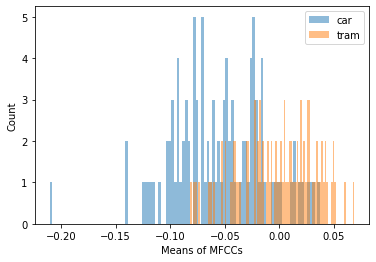

In [136]:
means = np.mean(features_table[:, :5], axis = 1).reshape(int(len(car_train) + len(tram_train)),1)
print(means.shape)
plt.figure()
plt.hist(means[:len(car_train),0], bins = 100, alpha = 0.5) #car
plt.hist(means[len(car_train):,0], bins = 100, alpha = 0.5) #tram
plt.legend(('car', 'tram'))
plt.xlabel('Means of MFCCs')
plt.ylabel('Count')
plt.grid

Overal, it is acceptable in a way that we can rule out the area for 'car' class and the area for 'tram' class. Even though there is overlapping area, we have to keep in mind that this is just the mean values of the first 5 MFCC coefficients to show a better visualization.  In the model, we will still use all 20 feature coefficients for training, validating and testing.

# 3. Splitting data and define model

As said before, in this project, we will use the reccommended ratio to split the data
 - 70% for training data
 - 15% for validation data
 - 15% for testing data

We will use Nth- Nearest neighbor (NNN) model in this project.  
The NNN model is easy to understand and with such amount of data we have, the run time is not long.  The model is also easy to implement ourselves (which is shown in the report) and explain but we will the built-in function from scikit learn library.  

In [137]:
#Preparing the data and the corresponding ground truth classes
'''
In this part, for simplicity later in the model, we will prepare the data
and its corresponding class (car/tram)

For the corresponding class:
    - Car = "1"
    - Tram = "0"
'''
#training data
train_class1 = np.ones((len(car_train),1))
train_class2 = np.zeros((len(tram_train),1))
train_class = np.concatenate((train_class1, train_class2))
train_data = features_table
print("Train class array size: " + str(train_class.shape))
print("Train data array size: " + str(train_data.shape))

#validation data
valid_class1 = np.ones((len(car_valid), 1))
valid_class2 = np.zeros((len(tram_valid), 1))
valid_class = np.concatenate((valid_class1, valid_class2))
car_features_valid = np.array([np.mean(extract_features(x),axis=2) for x in car_valid])
tram_features_valid = np.array([np.mean(extract_features(x),axis=2) for x in tram_valid])
valid_data = np.vstack((car_features_valid, tram_features_valid))
valid_data[:,0] = valid_data[:,0]/valid_data[:,0].max() #normalizing
valid_data = valid_data.reshape((int(len(car_valid) + len(tram_valid)), 20)) #reshaping

print("Validation vlass array size: " + str(valid_class.shape))
print("Validation data array size: " + str(valid_data.shape))

#testing data
test_class1 = np.ones((len(car_test), 1))
test_class2 = np.zeros((len(tram_test), 1))
test_class = np.concatenate((test_class1, test_class2))
car_features_test = np.array([np.mean(extract_features(x),axis=2) for x in car_test])
tram_features_test = np.array([np.mean(extract_features(x),axis=2) for x in tram_test])
test_data = np.vstack((car_features_test, tram_features_test))
test_data[:,0] =test_data[:,0]/test_data[:,0].max() #normalizing
test_data = test_data.reshape((int(len(car_test) + len(tram_test)), 20)) #reshaping

print("Testing class array size: " + str(test_class.shape))
print("Testing data array size: " + str(test_data.shape))

Train class array size: (199, 1)
Train data array size: (199, 20)
Validation vlass array size: (39, 1)
Validation data array size: (39, 20)
Testing class array size: (40, 1)
Testing data array size: (40, 20)


The Nth Nearest Neighbors has 2 type of weights in general:
 - uniform 
 - distance
We will now train the model and use validation data to see the best model version to gain the most accuracy.  We will also validate with different k radius value for the model. 

In [138]:
#Type of model by weight 
weights = ["uniform", "distance"]

#Type of model version by k
k_values = [1, 3, 5, 7, 9]

w = weights[0]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors= k, weights = w)
    knn.fit(train_data, train_class.ravel())
    
    valid_pred = knn.predict(valid_data)
    print('Info of {} Nearest neighbor with weights = {}'.format(k, w))
    print(classification_report(valid_pred, valid_class))

w = weights[1]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors= k, weights = w)
    knn.fit(train_data, train_class.ravel())
    
    valid_pred = knn.predict(valid_data)
    print('Info of {} Nearest neighbor with weights = {}'.format(k, w))
    print(classification_report(valid_pred, valid_class))

Info of 1 Nearest neighbor with weights = uniform
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.89        17
         1.0       1.00      0.82      0.90        22

    accuracy                           0.90        39
   macro avg       0.90      0.91      0.90        39
weighted avg       0.92      0.90      0.90        39

Info of 3 Nearest neighbor with weights = uniform
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        20
         1.0       0.94      0.89      0.92        19

    accuracy                           0.92        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.92      0.92      0.92        39

Info of 5 Nearest neighbor with weights = uniform
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        20
         1.0       0.94      0.89      0.92        19

    accuracy                    

As seen from the classification report and analyze the accuracy, precision and recal values (shown in report), we have now finalize our model and will now proceed with the training and testing with our own data (which is considered to be unseen data) 

# 4. Train the model and analyse the result

In [139]:
#the final model 
saved_w = 'distance'
#saved_w = 'uniform'
saved_k = 7
#saved_k = 9
def k_nearest_neighbor(X):
    '''
    X: array of input that wants to be classified
    X can have length 1 or more
    '''
    knn = KNeighborsClassifier(n_neighbors= saved_k, weights = saved_w)
    knn.fit(train_data, train_class.ravel())
    return knn.predict(X)

In [140]:
#Testing with our own testing files
test_pred = k_nearest_neighbor(test_data)
print(classification_report(test_pred, test_class))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        21
         1.0       0.95      1.00      0.97        19

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



From the report above, we can see that the result of accuracy is high and acceptable.  We can now say that the project is done successfully.